# check lerobot data

# check zarr data

In [39]:
import cv2
import zarr
import numpy as np
import matplotlib.pyplot as plt

# draw dataset
dataset_path = "/home/camille/IL/kuavodatalab/data-convert/data-example/Task1-RearangeToy/kuavo-zarr/Task1-RearangeToy.zarr"
dataset_path = "/app/data-convert/data-example/Task1-RearangeToy/kuavo-zarr/Task1-RearangeToy.zarr"
dataset_path = "/wks/dataset/dataset_wason_20250307/kuavo-zarr/Task11_Toy.zarr"
dataset_path = "/wks/dataset/kuavo-zarr/Task10-SuZhou.zarr"
dataset_root = zarr.open(dataset_path, 'r')

print(dataset_root.tree())
'''/
 ├── data
 │   ├── delta_eef_a (31301, 14) float32
 │   ├── eef_a (31301, 14) float32
 │   ├── eef_s (31301, 14) float32
 │   ├── img01 (31301, 256, 256, 3) uint8
 │   ├── img02 (31301, 256, 256, 3) uint8
 │   ├── joint_a (31301, 16) float32
 │   └── joint_s (31301, 16) float32
 └── meta
     └── episode_ends (201,) int64
'''

/
 ├── data
 │   ├── cmd_hand (360, 12) float64
 │   ├── cmd_joint (360, 14) float64
 │   ├── cmd_joint_with_hand (360, 26) float32
 │   ├── img01 (360, 384, 384, 3) uint8
 │   ├── img02 (360, 384, 384, 3) uint8
 │   ├── state_hand (360, 12) float64
 │   ├── state_joint (360, 14) float64
 │   ├── state_joint_with_hand (360, 26) float32
 │   └── timestamp (360,) float64
 └── meta
     └── episode_ends (3,) int64


'/\n ├── data\n │   ├── delta_eef_a (31301, 14) float32\n │   ├── eef_a (31301, 14) float32\n │   ├── eef_s (31301, 14) float32\n │   ├── img01 (31301, 256, 256, 3) uint8\n │   ├── img02 (31301, 256, 256, 3) uint8\n │   ├── joint_a (31301, 16) float32\n │   └── joint_s (31301, 16) float32\n └── meta\n     └── episode_ends (201,) int64\n'

# OFFLINE EVAL

## offline eval original_dp

In [30]:
model_ckpt_path = "/wks/dataset/dataset_wason_20250307/data/outputs/2025.03.07/21.26.03_train_diffusion_unet_image_Task11_Toy/checkpoints/latest.ckpt"
vis_camera_idx=0
init_joints=False
steps_per_inference=6
max_duration=60
frequency=10

import time
from multiprocessing.managers import SharedMemoryManager
import numpy as np
import torch
import dill
import hydra

from diffusion_policy.real_world.real_inference_util import (
    get_real_obs_resolution, 
    get_real_obs_dict)
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.policy.base_image_policy import BaseImagePolicy
from diffusion_policy.common.cv2_util import get_image_transform


# load checkpoint
ckpt_path = model_ckpt_path
payload = torch.load(open(ckpt_path, 'rb'), pickle_module=dill)
cfg = payload['cfg']
cls = hydra.utils.get_class(cfg._target_)
workspace = cls(cfg)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)

# hacks for method-specific setup.
action_offset = 0
delta_action = False
if 'diffusion' in cfg.name:
    # diffusion model
    policy: BaseImagePolicy
    policy = workspace.model
    if cfg.training.use_ema:
        policy = workspace.ema_model
    device = torch.device('cuda')
    policy.eval().to(device)
    # set inference params
    policy.num_inference_steps = 16 # DDIM inference iterations
    policy.n_action_steps = 32
elif 'robomimic' in cfg.name:
    # BCRNN model
    policy: BaseImagePolicy
    policy = workspace.model
    device = torch.device('cuda')
    policy.eval().to(device)
    # BCRNN always has action horizon of 1
    steps_per_inference = 1
    action_offset = cfg.n_latency_steps
    delta_action = cfg.task.dataset.get('delta_action', False)
elif 'ibc' in cfg.name:
    policy: BaseImagePolicy
    policy = workspace.model
    policy.pred_n_iter = 5
    policy.pred_n_samples = 4096
    device = torch.device('cuda')
    policy.eval().to(device)
    steps_per_inference = 1
    action_offset = 1
    delta_action = cfg.task.dataset.get('delta_action', False)
else:
    raise RuntimeError("Unsupported policy type: ", cfg.name)

In [31]:
# setup experiment
dt = 1/frequency
print(cfg)
obs_res = get_real_obs_resolution(cfg.task.shape_meta)
n_obs_steps = cfg.n_obs_steps
print("n_obs_steps: ", n_obs_steps)
print("steps_per_inference:", steps_per_inference)
print("action_offset:", action_offset)
print('n_action_steps', cfg.n_action_steps)

{'name': 'train_diffusion_unet_image', '_target_': 'diffusion_policy.workspace.train_diffusion_unet_image_workspace.TrainDiffusionUnetImageWorkspace', 'task_name': 'Task11_Toy', 'shape_meta': {'obs': {'img01': {'shape': [3, 384, 384], 'type': 'rgb'}, 'img02': {'shape': [3, 384, 384], 'type': 'rgb'}, 'agent_pos': {'shape': [8], 'type': 'low_dim'}}, 'action': {'shape': [8]}}, 'exp_name': 'default', 'horizon': 16, 'n_obs_steps': 2, 'n_action_steps': 8, 'n_latency_steps': 0, 'dataset_obs_steps': 2, 'past_action_visible': False, 'keypoint_visible_rate': 1.0, 'obs_as_global_cond': True, 'policy': {'_target_': 'diffusion_policy.policy.diffusion_unet_image_policy.DiffusionUnetImagePolicy', 'shape_meta': {'obs': {'img01': {'shape': [3, 384, 384], 'type': 'rgb'}, 'img02': {'shape': [3, 384, 384], 'type': 'rgb'}, 'agent_pos': {'shape': [8], 'type': 'low_dim'}}, 'action': {'shape': [8]}}, 'noise_scheduler': {'_target_': 'diffusers.schedulers.scheduling_ddim.DDIMScheduler', 'num_train_timesteps': 1

In [32]:
def draw_predicted_result(task_name, images, images02, pred_actions, true_actions, true_states):
    import numpy as np
    import matplotlib.pyplot as plt

    ACTION_DIM_LABELS = ['1', '2', '3', '4', '5', '6', '7', 'grasp']

    # Build image strips to show above actions
    img_strip = np.concatenate(np.array(images[::10]), axis=1)  # Row for images
    img_strip02 = np.concatenate(np.array(images02[::10]), axis=1)  # Row for images02

    # Stack image strips vertically
    img_strip_combined = np.vstack([img_strip, img_strip02])

    # Set up plt figure
    figure_layout = [
        ['image'] * len(ACTION_DIM_LABELS),
        ACTION_DIM_LABELS
    ]

    plt.rcParams.update({'font.size': 12})
    fig, axs = plt.subplot_mosaic(figure_layout)
    fig.set_size_inches([40, 10])  # Adjust height for two image strips
    fig.suptitle(task_name, fontsize=16)

    # Plot actions
    pred_actions = np.array(pred_actions).squeeze()
    true_actions = np.array(true_actions).squeeze()
    true_states = np.array(true_states).squeeze()
    for action_dim, action_label in enumerate(ACTION_DIM_LABELS):
        # Actions have batch, horizon, dim. In this example, we take the first action for simplicity.
        axs[action_label].plot(true_actions[:, action_dim], label='ground truth', alpha=0.5, zorder=1)
        axs[action_label].plot(pred_actions[:, 0, action_dim], label='predicted action', zorder=2)
        # axs[action_label].plot(true_states[:, action_dim], label='ground truth state')
        axs[action_label].set_title(action_label)
        axs[action_label].set_xlabel('Time in one episode')
        axs[action_label].legend()

    axs['image'].imshow(img_strip_combined)
    axs['image'].set_xlabel('Time in one episode (subsampled)')
    axs['image'].set_title('Image Comparison (Top: images, Bottom: images02)')

    plt.legend()
    plt.show()


### Kuavo

In [40]:
import cv2
import zarr
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, Callable, Tuple
import numpy as np
from diffusion_policy.common.cv2_util import get_image_transform


# test a episode
# dataset_path = "/home/leju-ali/hx/kuavo/Task8-SuZhou/kuavo-zarr/Task8-SuZhou.zarr"
dataset_root = zarr.open(dataset_path, 'r')
print(dataset_root.tree())

train_image_data01 = dataset_root['data']['img01']
train_image_data02 = dataset_root['data']['img02']

# train_image_data = np.moveaxis(train_image_data, -1, 1)
train_data = {    
    'img01':train_image_data01,
    'img02':train_image_data02,
    'agent_pos': dataset_root['data']['state_joint_with_hand'][:,:8],
    'action': dataset_root['data']['cmd_joint_with_hand'][:,:8],
}
episode_ends = dataset_root['meta']['episode_ends']

# plot first 10 episodes and record the video
all_pred_actions = []
all_true_actions = []
all_true_states = []

all_images01 = []  
all_images02 = []  
all_agent_poses = []
all_actions = []

for i in range(0,2):
    start_idx = 0
    if i > 0:
        start_idx = episode_ends[i-1]
    end_idx = episode_ends[i]
    episode_length = end_idx - start_idx
    
    obs_sequencia = {
        'img01': train_data['img01'][start_idx:end_idx],
        'img02': train_data['img02'][start_idx:end_idx],
        'agent_pos': train_data['agent_pos'][start_idx:end_idx],   
    }
    act_sequencia = train_data['action'][start_idx:end_idx]
    print(f"Episode {i} length: {episode_length}")
    
    all_images01.append(obs_sequencia['img01'])
    all_images02.append(obs_sequencia['img02'])
    all_agent_poses.append(obs_sequencia['agent_pos'])
    all_actions.append(act_sequencia)
    # ===================predict horizon actions with n_obs_steps observations===================
    import tqdm
    pred_actions, true_actions,true_states = [], [], []
    images01 = obs_sequencia['img01']
    images02 = obs_sequencia['img02']
    agent_poses = obs_sequencia['agent_pos']
    actions = act_sequencia
    
    # ##################
    # change grip always 0
    # ##################
    # agent_poses[:, 6] = 0
    # rec_gripper_state = 0
    WINDOW_SIZE = n_obs_steps
    for step in tqdm.trange(len(images01) - (WINDOW_SIZE - 1)):
        input_images01 = np.stack(images01[step:step+WINDOW_SIZE])
        input_images02 = np.stack(images02[step:step+WINDOW_SIZE])
        input_agent_poses = np.stack(agent_poses[step:step+WINDOW_SIZE])
        
        # input_agent_poses[:, 6] = 1 if rec_gripper_state == 1 else 0
            
        obs = {
            'img01': input_images01,
            'img02': input_images02,
            'agent_pos': input_agent_poses
        }
        # run inference
        with torch.no_grad():
            s = time.time()
            obs_dict_np = get_real_obs_dict(
                env_obs=obs, shape_meta=cfg.task.shape_meta)
            obs_dict = dict_apply(obs_dict_np, 
                lambda x: torch.from_numpy(x).unsqueeze(0).to(device))
            result = policy.predict_action(obs_dict)
            # this action starts from the first obs step
            action = result['action'][0].detach().to('cpu').numpy()
            # print('Inference latency:', time.time() - s)
            
            # action (n_action_steps, action_dim)
            # rec_gripper_state = 1 if action[0, -1] > 0.5 else 0
            
        pred_actions.append(action) # (horizon, action_dim)
        final_window_step = step + WINDOW_SIZE - 1
        true_actions.append(np.array(actions[final_window_step]))
        true_states.append(np.array(agent_poses[final_window_step]))
    all_pred_actions.append(pred_actions)
    all_true_actions.append(true_actions)
    all_true_states.append(true_states)

/
 ├── data
 │   ├── cmd_hand (360, 12) float64
 │   ├── cmd_joint (360, 14) float64
 │   ├── cmd_joint_with_hand (360, 26) float32
 │   ├── img01 (360, 384, 384, 3) uint8
 │   ├── img02 (360, 384, 384, 3) uint8
 │   ├── state_hand (360, 12) float64
 │   ├── state_joint (360, 14) float64
 │   ├── state_joint_with_hand (360, 26) float32
 │   └── timestamp (360,) float64
 └── meta
     └── episode_ends (3,) int64
Episode 0 length: 102


100%|██████████| 101/101 [00:14<00:00,  6.75it/s]


Episode 1 length: 147


100%|██████████| 146/146 [00:21<00:00,  6.75it/s]


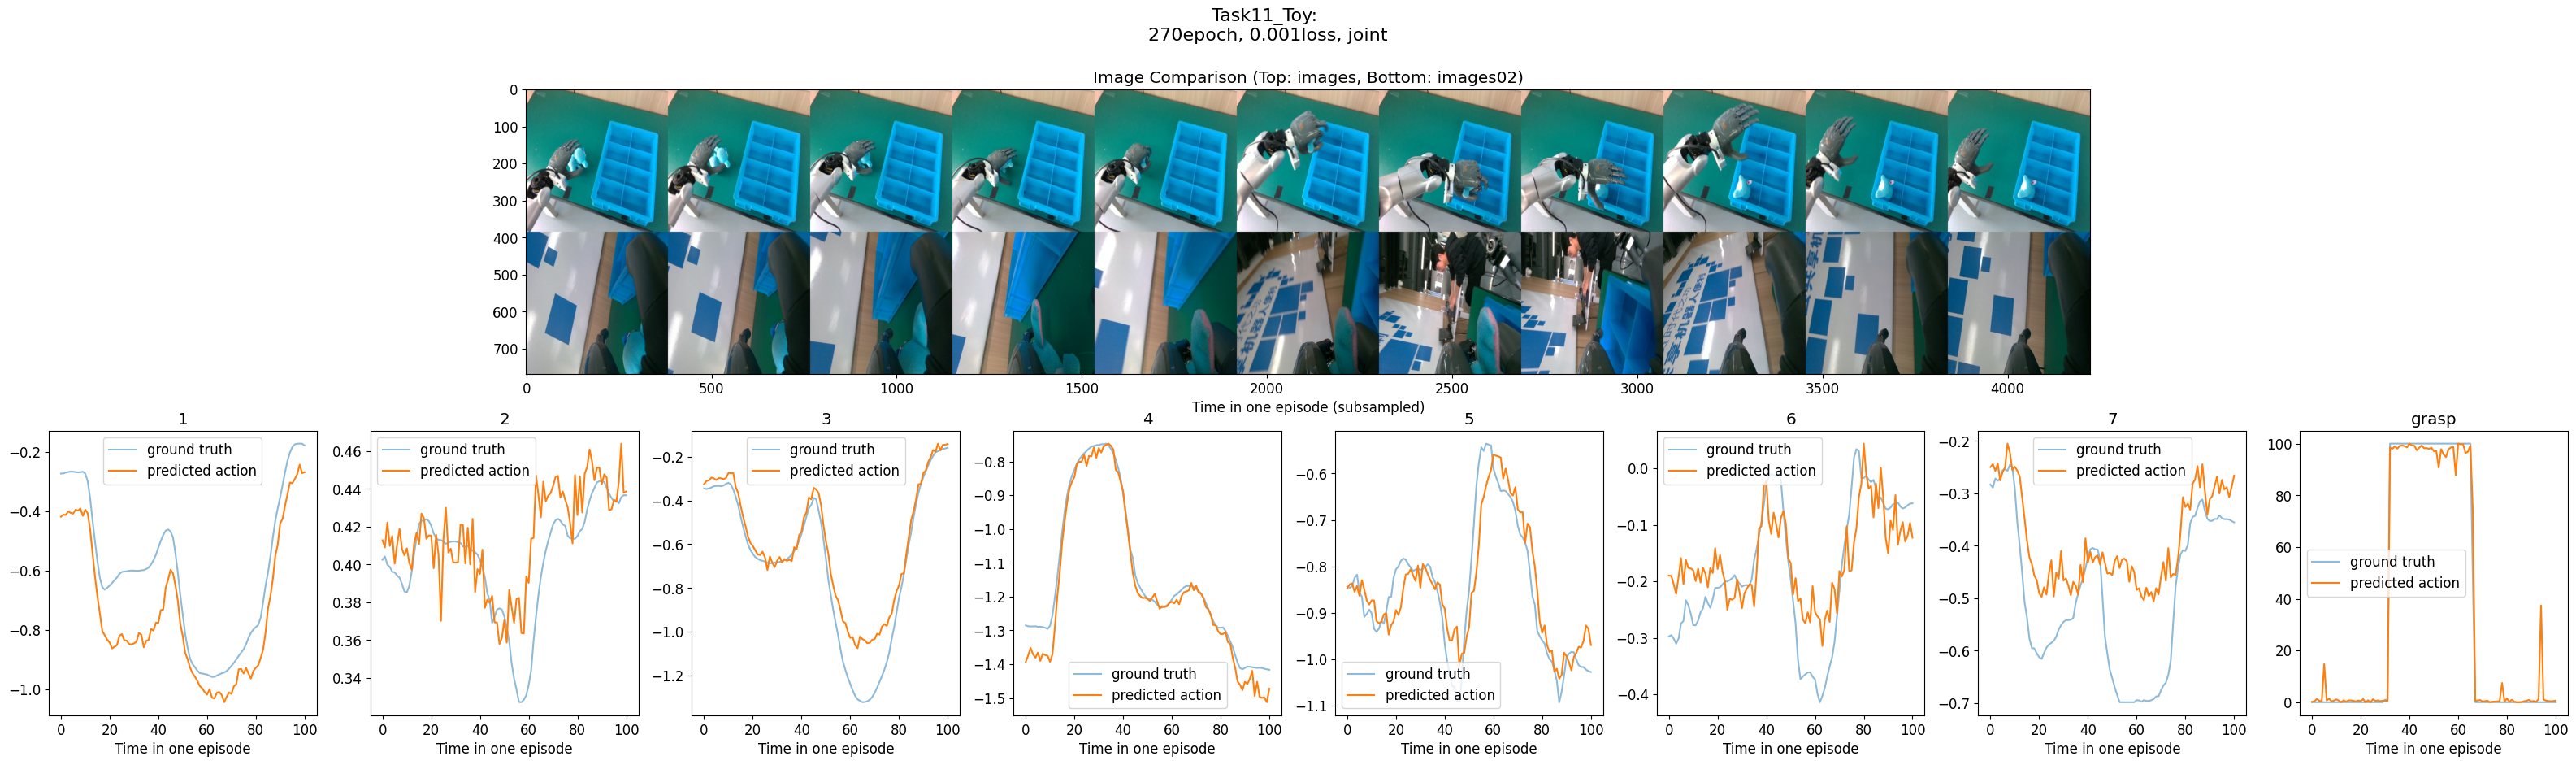

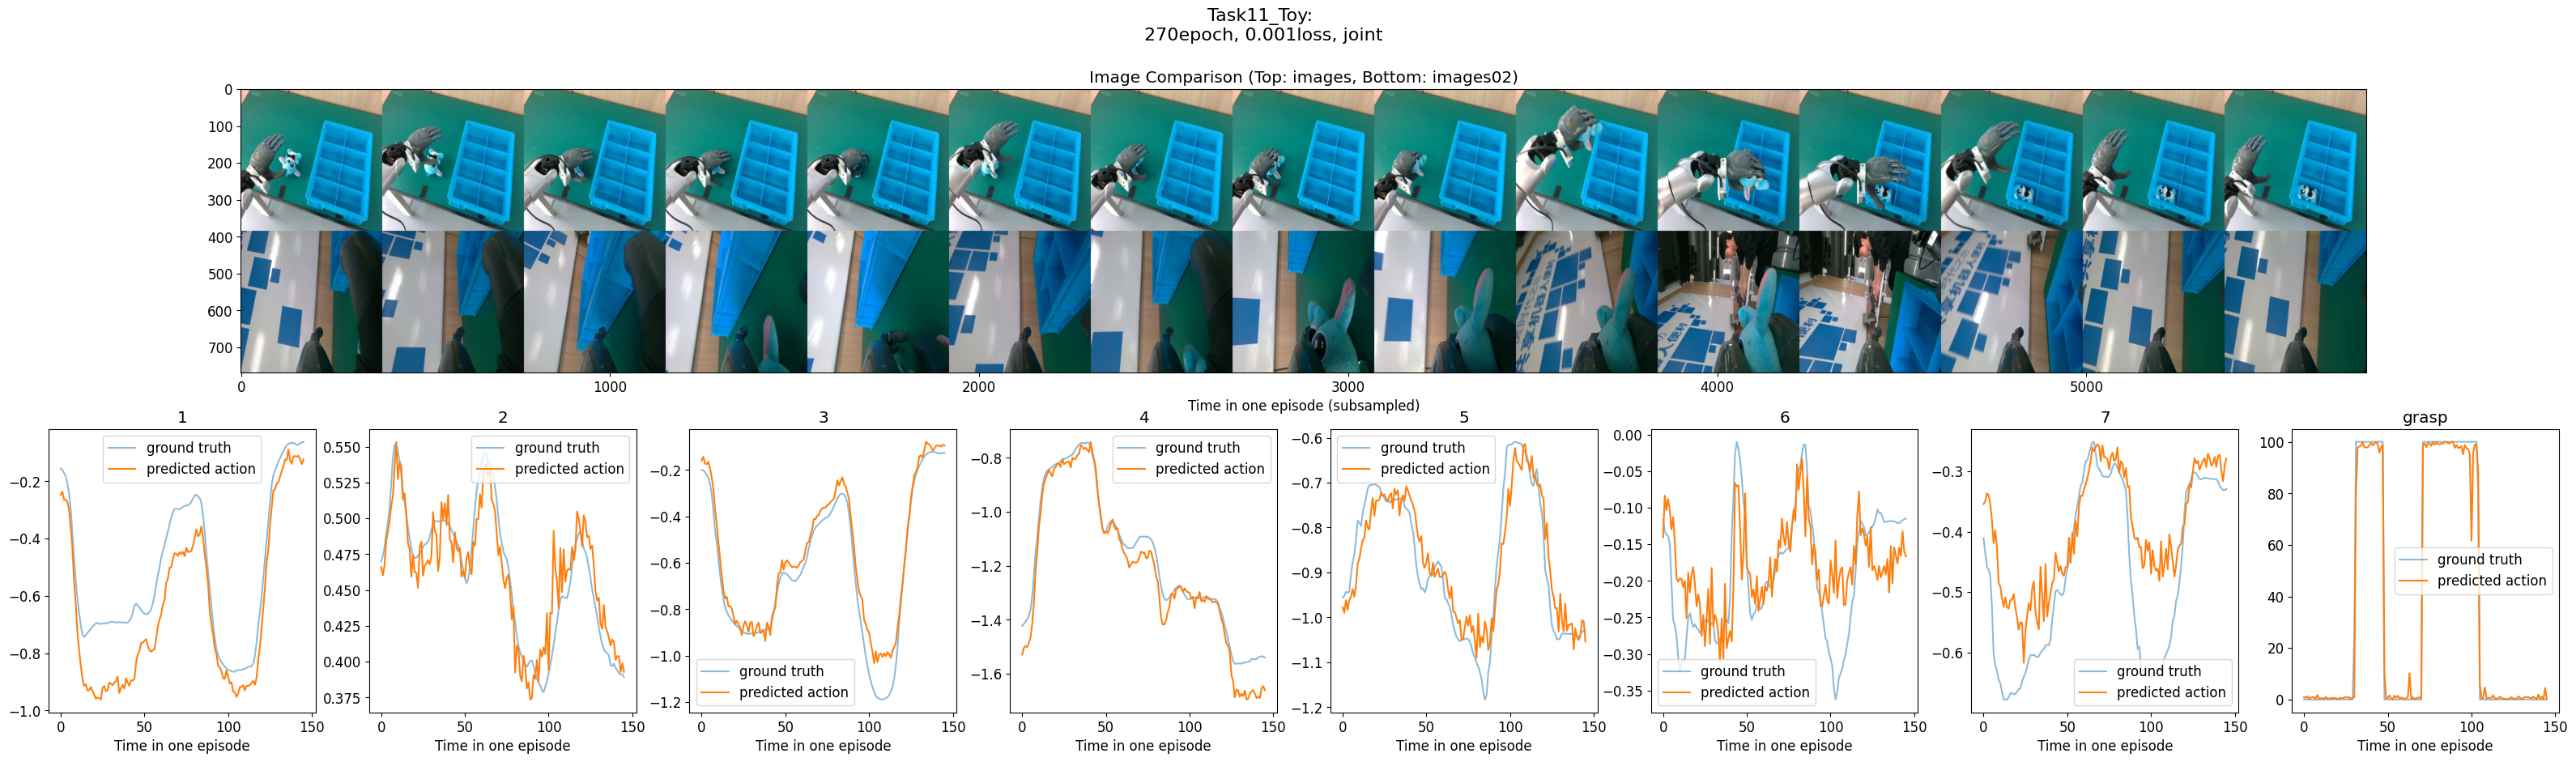

In [41]:
task_name = 'Task11_Toy: \n270epoch, 0.001loss, joint'
for i in range(len(all_images01)):
    draw_predicted_result(task_name, all_images01[i], all_images02[i],all_pred_actions[i], all_true_actions[i], all_true_states[i],)